NameError: name 'x_min' is not defined

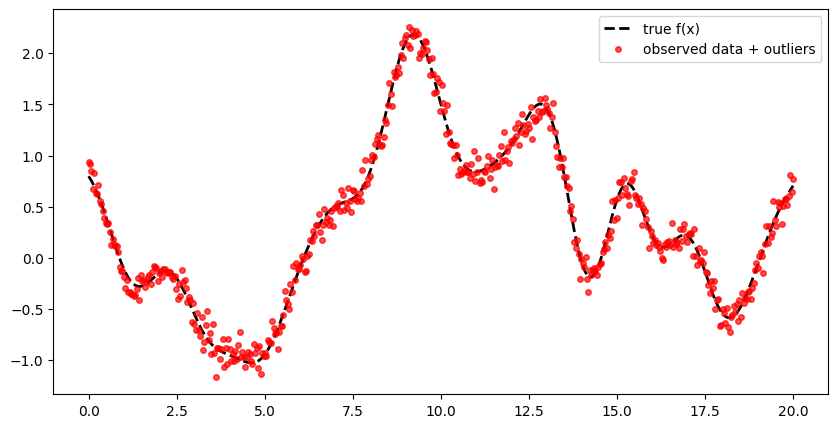

In [5]:
from typing import Optional
from zipfile import ZIP_BZIP2

import tensorflow as tf

tf.keras.backend.set_floatx('float64')
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel

from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye

import random
import numpy as np

from numpy.lib.twodim_base import histogram2d
from scipy.ndimage import variance

from tensorboard.plugins.histogram.summary import histogram
from tensorflow.python.ops.variables import trainable_variables

import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 500
sigma_n = .1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)
y_obs = f + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x
"""
arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

upp=2
low=1
y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

# ... [your existing imports and setup code above] ...

# After generating x_obs, y_obs:
"""
"""
# 1. Select 10 outlier positions outside the current data range:
n_outliers = 10
x_min, x_max = float(x.min()), float(x.max())
outlier_spread = 20.0  # how far beyond the range
x_outliers = np.random.uniform(
    low=x_min - outlier_spread,
    high=x_min - 0.1 * outlier_spread,
    size=(n_outliers // 2, 1)
)
x_outliers = np.vstack([
    x_outliers,
    np.random.uniform(
        low=x_max + 0.1 * outlier_spread,
        high=x_max + outlier_spread,
        size=(n_outliers - x_outliers.shape[0], 1)
    )
])

# 2. Assign y-values to outliers (e.g., sample from prior + noise):
#    You can sample from the GP prior covariance or set them arbitrarily
K_xo = kernel(x_outliers, x_outliers)
y_outliers = np.random.multivariate_normal(
    mean=np.zeros(n_outliers),
    cov=K_xo + sigma_n**2 * np.eye(n_outliers)
).reshape(-1, 1)

# 3. Append to the observed data, preserving order:
x_aug = np.vstack([x_obs, x_outliers])
y_aug = np.vstack([y_obs, y_outliers])
order = np.argsort(x_aug[:, 0])
x_obs, y_obs = x_aug[order], y_aug[order]

# Now X and y include the new outliers:
X = x  # untouched original full domain
y = y_obs  # augmented observations

# 4. Plot:
"""
plt.figure(figsize=(10, 5))
plt.plot(x, f, 'k--', lw=2, label='true f(x)')
plt.plot(x_obs, y_obs, 'r.', ms=8, alpha=0.7, label='observed data + outliers')
plt.legend()
plt.xlim(x_min - outlier_spread, x_max + outlier_spread)
plt.show()


ONLY LAMBDA HYPER

In [6]:

import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_FI_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        self.lambda_i = gpflow.Parameter(10,transform=gpflow.utilities.positive(),trainable=False)
        #self.sigma=tf.Variable(0.3,dtype=tf.float64,trainable=False)
        self.a_p = tf.constant(1.0,dtype=tf.float64)
        self.b_p = tf.constant(1.0,dtype=tf.float64)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)

    def maximum_log_likelihood_objective(self):
        pass


    def train_step(self):

        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)
        
        #
        self.lambda_i.assign(N+1/(tf.reduce_sum((self.y-mu_f)**2+tf.linalg.trace(Sigma_f))))

        # Loss terms
        term1 =  tf.transpose(self.y-mu_f) @ (eye *self.lambda_i**2) @ (self.y-mu_f)
        term4 = self.lambda_i**2* tf.linalg.trace(Sigma_f)-N*self.lambda_i
        term3 = -tfp.distributions.Gamma(self.a_p,self.b_p).log_prob(self.lambda_i)

        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2 +term3 + term4 + term5)
        self.lambda_i.assign(N+1/(tf.reduce_sum((self.y-mu_f)**2+tf.linalg.trace(Sigma_f))))
        return loss
        

    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K

    def update_lambda(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)

        self.lambda_i.assign(N+1/(tf.reduce_sum((self.y-mu_f)**2+tf.linalg.trace(Sigma_f))))
        
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
            self.update_lambda()


    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [7]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_GP_MSE_alpha(x_obs,y_obs,inducing_variable)
model.internal_opt()
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'flo

<tf.Tensor: shape=(), dtype=float64, numpy=0.0025009205582486814>

In [8]:
model.trainable_variables

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-0.45363683400880395>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-0.3303123797700186>)

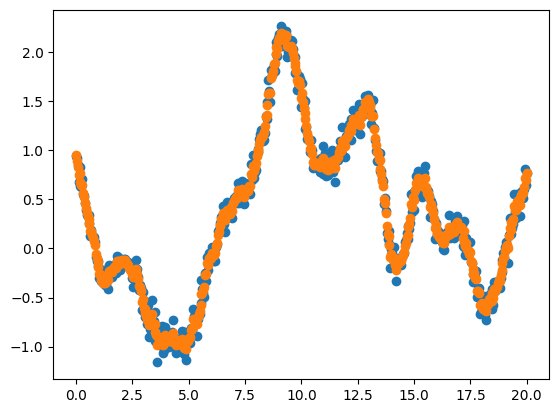

In [9]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,model.mu_f)

In [70]:

import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_MSE_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        self.lambda_i = gpflow.Parameter(10,transform=gpflow.utilities.positive())
        #self.sigma=tf.Variable(0.3,dtype=tf.float64,trainable=False)
        self.a_p = tf.constant(10.0,dtype=tf.float64)
        self.b_p = tf.constant(10.0,dtype=tf.float64)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)

    def maximum_log_likelihood_objective(self):
        pass


    def train_step(self):

        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 =  tf.transpose(self.y-mu_f) @ (eye *self.lambda_i**2) @ (self.y-mu_f)
        term4 = self.lambda_i**2* tf.linalg.trace(Sigma_f)-N*self.lambda_i
        term3 = -tfp.distributions.Gamma(self.a_p,self.b_p).log_prob(self.lambda_i)

        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2  +term3 + term4 + term5)
        #self.lambda_i.assign(N+self.b_p/(tf.reduce_sum((self.y-mu_f)**2+tf.linalg.trace(Sigma_f))))
        return loss
        

    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K

    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape() as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
            



    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [71]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_GP_MSE_alpha(x_obs,y_obs,inducing_variable)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<dtype: 'float64'>


2025-07-24 18:47:43.355299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.
	 [[{{node MatrixInverse}}]]


InvalidArgumentError: Graph execution error:

Detected at node MatrixInverse defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 640, in run_forever

  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1992, in _run_once

  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_3574/3839403679.py", line 6, in <module>

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 159, in minimize

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py", line 713, in minimize

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_lbfgsb_py.py", line 309, in _minimize_lbfgsb

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py", line 402, in _prepare_scalar_function

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 166, in __init__

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 262, in _update_fun

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 163, in update_fun

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 145, in fun_wrapped

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py", line 78, in __call__

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py", line 72, in _compute_if_needed

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 224, in _eval

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 190, in _tf_eval

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 192, in _tf_eval

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 329, in _compute_loss_and_gradients

  File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_3574/2395936006.py", line 37, in train_step

Input is not invertible.
	 [[{{node MatrixInverse}}]] [Op:__inference__tf_eval_34644]

In [66]:
model.trainable_variables

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.5413248546129181>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.5413248546129181>)

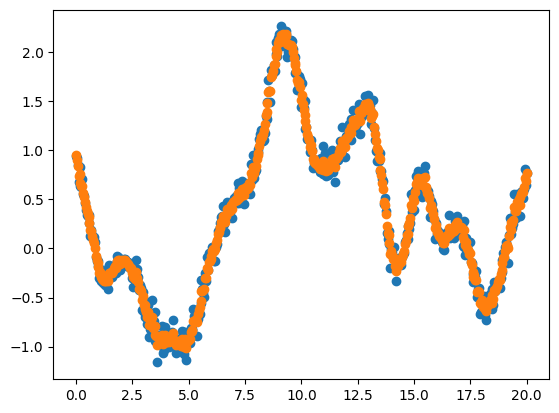

In [67]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,model.mu_f)

In [121]:
model.a_q*(model.a_q+1)/(model.b_q**2)*model.sigma**(-4)

<tf.Tensor: shape=(), dtype=float64, numpy=15.401376254045244>

In [122]:
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

opt = gpflow.optimizers.Scipy()
opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

f_mean, f_var = standard_gp.predict_f(x_obs, full_cov=False)

In [123]:
tf.reduce_mean((f_mean - f) ** 2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.007743825173607345>

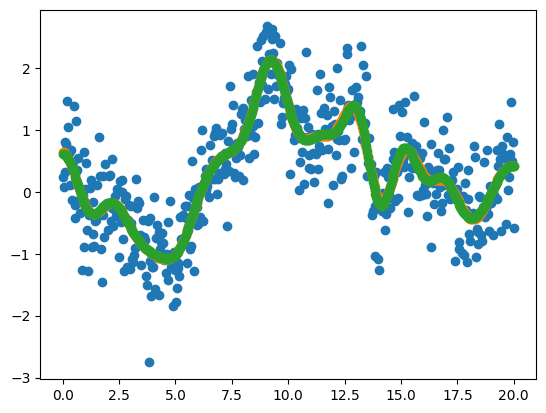

In [124]:

plt.scatter(x_obs, y_obs)
plt.scatter(x_obs, model.mu_f)
plt.scatter(x_obs, f_mean)


NOW I WRITE IT FOR THE MSE


In [125]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_MSE_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        self.a_q = gpflow.Parameter(5.0,transform=gpflow.utilities.positive())
        self.b_q = gpflow.Parameter(2.0,transform=gpflow.utilities.positive())
        self.a_p = tf.constant(1.0,dtype=tf.float64)
        self.b_p = tf.constant(1.0,dtype=tf.float64)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    

    def kl_gamma(self,alpha_p, beta_p, alpha_q, beta_q):
        term1 = (-alpha_q + alpha_p) * tf.math.digamma(alpha_p)
        term2 = -tf.math.lgamma(alpha_p) + tf.math.lgamma(alpha_q)
        term3 = -alpha_q * tf.math.log(beta_q / beta_p)
        term4 = beta_q
        return term1 + term2 + term3 + term4
    
  
    def train_step(self):
        
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *self.a_q*(self.a_q+1)/self.b_q**2)
        q2 = tf.matmul(eye*self.a_q*(self.a_q+1)/self.b_q**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 = 0.5 * tf.transpose(self.y-mu_f) @ (eye *self.a_q*(self.a_q+1)/self.b_q**2) @ (self.y-mu_f)
        term4 = 0.5 *self.a_q*(self.a_q+1)/self.b_q**2* tf.linalg.trace(Sigma_f)-N*self.a_q/self.b_q
        term3 = self.kl_gamma(self.a_p,self.b_p, self.a_q, self.b_q)
        
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2  + term3 + term4 + term5)
        return loss
        
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.a_q*(1+self.a_q)/self.b_q**2))
        q2 = tf.matmul(eye *self.a_q*(1+self.a_q)/self.b_q**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K
        
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape() as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))


    
    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [126]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_GP_MSE_alpha(x_obs,y_obs,inducing_variable)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<dtype: 'float64'>
<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=0.010184787258000164>

In [127]:
 model.trainable_variables

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=27.698198412896918>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=7.7292884317124155>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.23241713504190423>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-3.2276837280178636>)

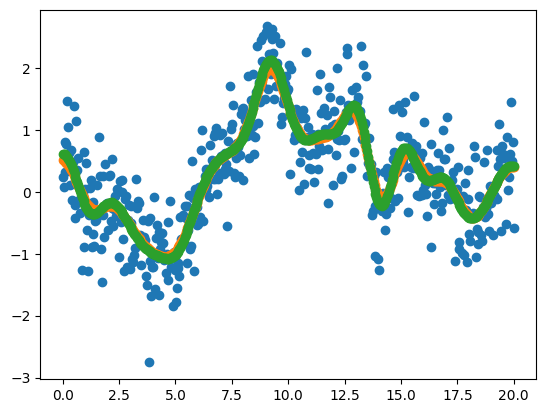

In [128]:
plt.scatter(x_obs, y_obs)
plt.scatter(x_obs, model.mu_f)
plt.scatter(x_obs, f_mean)

In [112]:
model.a_q*(model.a_q+1)/(model.b_q**2)

<tf.Tensor: shape=(), dtype=float64, numpy=inf>

In [5]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_MSE_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        #self.p_q=gpflow.Parameter(0.1,trainable=False)
        self.p_q = gpflow.Parameter(.1,trainable=False,transform=gpflow.utilities.positive())
    
    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self):
        
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye /self.p_q**2)
        q2 = tf.matmul(eye/self.p_q**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 =  0.5*tf.transpose(self.y-mu_f) @ (eye /self.p_q**2) @ (self.y-mu_f)-N/(self.p_q)
        term4 = 1 / self.p_q * tf.linalg.trace(Sigma_f)
        #term3 = (1-self.p_q)-tf.math.log(self.p_q)
        
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2  + term4 + term5)
     
        return loss
        self.p_q.assign(tf.reduce_sum(tf.transpose(self.y-mu_f)@ (self.y-mu_f)/N))
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye /self.p_q)
        q2 = tf.matmul(eye/self.p_q, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K
    
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.001)
        for i in range(n_it):
            with tf.GradientTape() as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))

    
    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [6]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_GP_MSE_alpha(x_obs,y_obs,inducing_variable)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<dtype: 'float64'>
<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=1.2271829655207305>

In [7]:
model.trainable_variables

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.12464730657784522>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-3.391960730177301>)

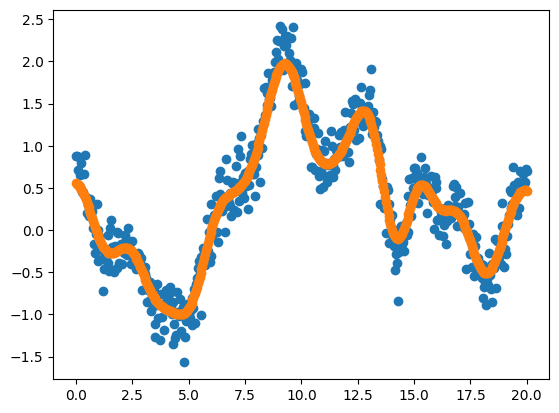

In [8]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,model.mu_f)

In [11]:
1/model.p_q

<tf.Tensor: shape=(), dtype=float64, numpy=1634.0933943136358>

In [12]:
model.trainable_variables


(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-7.398537434982122>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-13.182596659844235>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-4.182487518221261>)

In [16]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.,sigma=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        self.sigma=gpflow.Parameter(sigma, transform=gpflow.utilities.positive())

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self):
        
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma**2)
        q2 = tf.matmul(eye / self.sigma**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 = 0.5 * tf.transpose(self.y-mu_f) @ (eye*self.sigma**(-2)) @ (self.y-mu_f)
        term3 = N* tf.math.log(self.sigma)
        term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(Sigma_f)
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2 + term3 + term4 + term5)
        print(loss)
     
        return loss
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma**2)
        q2 = tf.matmul(eye / self.sigma**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K
    
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.001)
        for i in range(n_it):
            with tf.GradientTape() as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            print(loss)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))

    
    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [17]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_GP_alpha(x_obs,y_obs,inducing_variable)
model.internal_opt()
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<dtype: 'float64'>
Tensor("Squeeze:0", shape=(), dtype=float64)
tf.Tensor(304.24372960556866, shape=(), dtype=float64)
tf.Tensor(304.03257727383675, shape=(), dtype=float64)
tf.Tensor(303.8217141908455, shape=(), dtype=float64)
tf.Tensor(303.61105295322875, shape=(), dtype=float64)
tf.Tensor(303.4006110273751, shape=(), dtype=float64)
tf.Tensor(303.19033896507096, shape=(), dtype=float64)
tf.Tensor(302.9802957879983, shape=(), dtype=float64)
tf.Tensor(302.77049474545623, shape=(), dtype=float64)
tf.Tensor(302.5609549851053, shape=(), dtype=float64)
tf.Tensor(302.35160829207905, shape=(), dtype=float64)
tf.Tensor(302.14251209258504, shape=(), dtype=float64)
tf.Tensor(301.933657770745, shape=(), dtype=float64)
tf.Tensor(301.72503046269804, shape=(), dtype=float64)
tf.Tensor(301.5166938799717, shape=(), dtype=float64)
tf.Tensor(301.30852416924694, shape=(), dtype=float64)
tf.Tensor(301.100639334086, shape=(), dtype=float64)
tf.Tensor(300.8929838200392, shape=(), dtype=float64)
tf.Tensor(3

<tf.Tensor: shape=(), dtype=float64, numpy=1.2837885069876378>

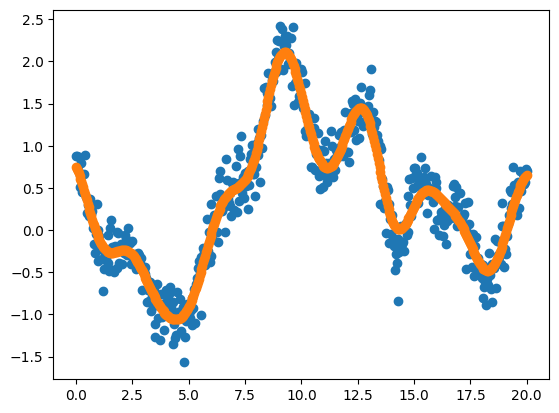

In [14]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,model.mu_f)